Scale Scikit-Learn for Small Data Problems
==========================================

Dask can be used to scale scikit-learn to a cluster of machines for a CPU-bound problem.
We will be using a local cluster with 4 workers, each with 1 thread.

In [1]:
from dask.distributed import Client, progress
client = Client(n_workers=4, threads_per_worker=1, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46155,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:45615,Total threads: 1
Dashboard: http://127.0.0.1:44057/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:37825,


## Distributed Training


Scikit-learn uses [joblib](http://joblib.readthedocs.io/) for single-machine parallelism. This lets you train most estimators (anything that accepts an `n_jobs` parameter) using all the cores of your laptop or workstation.

Alternatively, Scikit-Learn can use Dask for parallelism.  This lets you train those estimators using all the cores of your *cluster* without significantly changing your code.  This is most useful for training large models on medium-sized datasets. 

### Create Scikit-Learn Pipeline

In [2]:
from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [3]:
# Scale Up: set categories=None to use all the categories
categories = [
    'alt.atheism',
    'talk.religion.misc',
]

print("Loading 20 newsgroups dataset for categories:")
print(categories)

data = fetch_20newsgroups(subset='train', categories=categories)
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc']
857 documents
2 categories



We'll define a small pipeline that combines text feature extraction with a simple classifier.

In [4]:
pipeline = Pipeline([
    ('vect', HashingVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(max_iter=1000)),
])

In [5]:
pipeline

Pipeline(steps=[('vect', HashingVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier())])

### Define Grid for Parameter Search
Grid search over some parameters.
GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid. 

In [6]:
parameters = {
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    # 'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__n_iter': (10, 50, 80),
}

In [7]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3, refit=False)

To fit this normally, we would write


```python
grid_search.fit(data.data, data.target)
```

That would use the default joblib backend (multiple processes) for parallelism.
To use the Dask distributed backend, which will use a cluster of machines to train the model, perform the fit in a `parallel_backend` context.

In [8]:
import joblib

with joblib.parallel_backend('dask'):
    grid_search.fit(data.data, data.target)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [9]:
grid_search.best_score_

0.9358279147752832

In [10]:
grid_search.best_params_

{'clf__alpha': 1e-06, 'tfidf__norm': 'l1', 'tfidf__use_idf': True}

In [11]:
import pandas as pd
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_tfidf__norm,param_tfidf__use_idf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.302011,0.010583,0.075134,0.001749,0.00001,l1,True,"{'clf__alpha': 1e-05, 'tfidf__norm': 'l1', 'tf...",0.916084,0.940559,0.933333,0.929992,0.010268,2
1,0.246588,0.025059,0.049107,0.003402,0.00001,l1,False,"{'clf__alpha': 1e-05, 'tfidf__norm': 'l1', 'tf...",0.930070,0.919580,0.901754,0.917135,0.011688,6
2,0.238915,0.004901,0.076649,0.003073,0.00001,l2,True,"{'clf__alpha': 1e-05, 'tfidf__norm': 'l2', 'tf...",0.912587,0.937063,0.936842,0.928831,0.011486,3
3,0.157738,0.010296,0.049990,0.004001,0.00001,l2,False,"{'clf__alpha': 1e-05, 'tfidf__norm': 'l2', 'tf...",0.923077,0.923077,0.929825,0.925326,0.003181,4
4,0.262865,0.005986,0.078033,0.002844,0.000001,l1,True,"{'clf__alpha': 1e-06, 'tfidf__norm': 'l1', 'tf...",0.923077,0.944056,0.940351,0.935828,0.009142,1


Score and Predict Large Datasets
================================

Sometimes you'll train on a smaller dataset that fits in memory, but need to predict or score for a much larger (possibly larger than memory) dataset.
Perhaps your [learning curve](http://scikit-learn.org/stable/modules/learning_curve.html) has leveled off, or you only have labels for a subset of the data.

In this situation, you can use [ParallelPostFit](http://ml.dask.org/modules/generated/dask_ml.wrappers.ParallelPostFit.html) to parallelize and distribute the scoring or prediction steps.

In [12]:
from dask.distributed import Client, progress

# Scale up: connect to your own cluster with more resources
# see http://dask.pydata.org/en/latest/setup.html
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

/home/joseph/.local/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46481 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://150.203.163.92:46481/status,
Dashboard: http://150.203.163.92:46481/status,Workers: 1
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: False
Comm: inproc://150.203.163.92/3734122/1,Workers: 1
Dashboard: http://150.203.163.92:46481/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: inproc://150.203.163.92/3734122/4,Total threads: 4
Dashboard: http://150.203.163.92:43941/status,Memory: 1.86 GiB
Nanny: None,


In [13]:
import numpy as np
import dask.array as da
from sklearn.datasets import make_classification

We'll generate a small random dataset with scikit-learn.

In [14]:
X_train, y_train = make_classification(
    n_features=2, n_redundant=0, n_informative=2,
    random_state=1, n_clusters_per_class=1, n_samples=1000)
X_train[:5]

array([[ 1.53682958, -1.39869399],
       [ 1.36917601, -0.63734411],
       [ 0.50231787, -0.45910529],
       [ 1.83319262, -1.29808229],
       [ 1.04235568,  1.12152929]])

And we'll clone that dataset many times with `dask.array`. `X_large` and `y_large` represent our larger than memory dataset.

In [15]:
# Scale up: increase N, the number of times we replicate the data.
N = 100
X_large = da.concatenate([da.from_array(X_train, chunks=X_train.shape)
                          for _ in range(N)])
y_large = da.concatenate([da.from_array(y_train, chunks=y_train.shape)
                          for _ in range(N)])
X_large

dask.array<concatenate, shape=(100000, 2), dtype=float64, chunksize=(1000, 2), chunktype=numpy.ndarray>

Since our training dataset fits in memory, we can use a scikit-learn estimator as the actual estimator fit during traning.
But we know that we'll want to predict for a large dataset, so we'll wrap the scikit-learn estimator with `ParallelPostFit`.

In [16]:
from sklearn.linear_model import LogisticRegressionCV
from dask_ml.wrappers import ParallelPostFit

In [17]:
clf = ParallelPostFit(LogisticRegressionCV(cv=3), scoring="r2")

See the note in the `dask-ml`'s documentation about when and why a `scoring` parameter is needed: https://ml.dask.org/modules/generated/dask_ml.wrappers.ParallelPostFit.html#dask_ml.wrappers.ParallelPostFit.

Now we'll call `clf.fit`. Dask-ML does nothing here, so this step can only use datasets that fit in memory.

In [18]:
clf.fit(X_train, y_train)

ParallelPostFit(estimator=LogisticRegressionCV(cv=3), scoring='r2')

Now that training is done, we'll turn to predicting for the full (larger than memory) dataset.

In [19]:
y_pred = clf.predict(X_large)
y_pred

dask.array<_predict, shape=(100000,), dtype=int64, chunksize=(1000,), chunktype=numpy.ndarray>

`y_pred` is a Dask array.
Workers can write the predicted values to a shared file system, without ever having to collect the data on a single machine.

Or we can check the models score on the entire large dataset.
The computation will be done in parallel, and no single machine will have to hold all the data.

In [20]:
clf.score(X_large, y_large)

0.596

Incrementally Train Large Datasets
==================================

In [21]:
from dask.distributed import Client
client = Client(n_workers=4, threads_per_worker=1)
client

/home/joseph/.local/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46745 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:46745/status,
Dashboard: http://127.0.0.1:46745/status,Workers: 4
Total threads: 4,Total memory: 92.97 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40573,Workers: 4
Dashboard: http://127.0.0.1:46745/status,Total threads: 4
Started: Just now,Total memory: 92.97 GiB
Comm: tcp://127.0.0.1:41561,Total threads: 1
Dashboard: http://127.0.0.1:37283/status,Memory: 23.24 GiB
Nanny: tcp://127.0.0.1:35467,


## Create Data

We create a synthetic dataset that is large enough to be interesting, but small enough to run quickly.  

Our dataset has 1,000,000 examples and 100 features.

In [22]:
import dask
import dask.array as da
from dask_ml.datasets import make_classification


n, d = 100000, 100

X, y = make_classification(n_samples=n, n_features=d,
                           chunks=n // 10, flip_y=0.2)
X

/home/joseph/.local/lib/python3.8/site-packages/dask/base.py:1369: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


dask.array<normal, shape=(100000, 100), dtype=float64, chunksize=(10000, 100), chunktype=numpy.ndarray>

## Split data for training and testing

We split our dataset into training and testing data to aid evaluation by making sure we have a fair test:

In [23]:
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train

dask.array<concatenate, shape=(90000, 100), dtype=float64, chunksize=(9000, 100), chunktype=numpy.ndarray>

## Persist data in memory

This dataset is small enough to fit in distributed memory, so we call `dask.persist` to ask Dask to execute the computations above and keep the results in memory.

In [24]:
X_train, X_test, y_train, y_test = dask.persist(X_train, X_test, y_train, y_test)

If you are working in a situation where your dataset does not fit in memory then you should skip this step.  Everything will still work, but will be slower and use less memory.

Calling `dask.persist` will preserve our data in memory, so no computation will be needed as we pass over our data many times.  For example if our data came from CSV files and was not persisted, then the CSV files would have to be re-read on each pass.  This is desirable if the data does not fit in RAM, but not slows down our computation otherwise.

## Precompute classes

We pre-compute the classes from our training data, which is required for this classification example:

In [25]:
classes = da.unique(y_train).compute()
classes

array([0, 1])

## Create Scikit-Learn model

We make the underlying Scikit-Learn estimator, an `SGDClassifier`:

In [28]:
from sklearn.linear_model import SGDClassifier

est = SGDClassifier(loss='squared_error', penalty='l2', tol=1e-3)

Here we use `SGDClassifier`, but any estimator that implements the `partial_fit` method will work.  A list of Scikit-Learn models that implement this API is available [here](https://scikit-learn.org/stable/computing/scaling_strategies.html#incremental-learning).


## Wrap with Dask-ML's Incremental meta-estimator

We now wrap our `SGDClassifer` with the [`dask_ml.wrappers.Incremental`](http://ml.dask.org/modules/generated/dask_ml.wrappers.Incremental.html#dask_ml.wrappers.Incremental) meta-estimator.

In [29]:
from dask_ml.wrappers import Incremental

inc = Incremental(est, scoring='accuracy')

`Incremental` only does data management while leaving the actual algorithm to the underlying Scikit-Learn estimator.

Note: We set the scoring parameter above in the Dask estimator to tell it to handle scoring.  This works better when using Dask arrays for test data.

## Model training

`Incremental` implements a `fit` method, which will perform one loop over the dataset, calling `partial_fit` over each chunk in the Dask array.

You may want to watch the dashboard during this fit process to see the sequential fitting of many batches.

In [30]:
inc.fit(X_train, y_train, classes=classes)

Incremental(estimator=SGDClassifier(loss='squared_error'), scoring='accuracy')

In [31]:
inc.score(X_test, y_test)

0.4876

Train Models on Large Datasets
==============================

Most estimators in scikit-learn are designed to work with NumPy arrays or scipy sparse matricies.
These data structures must fit in the RAM on a single machine.

Estimators implemented in Dask-ML work well with Dask Arrays and DataFrames. This can be much larger than a single machine's RAM. They can be distributed in memory on a cluster of machines.

In [32]:
from dask.distributed import Client

# Scale up: connect to your own cluster with more resources
# see http://dask.pydata.org/en/latest/setup.html
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

/home/joseph/.local/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41129 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://150.203.163.92:41129/status,
Dashboard: http://150.203.163.92:41129/status,Workers: 1
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: False
Comm: inproc://150.203.163.92/3734122/10,Workers: 1
Dashboard: http://150.203.163.92:41129/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: inproc://150.203.163.92/3734122/13,Total threads: 4
Dashboard: http://150.203.163.92:38595/status,Memory: 1.86 GiB
Nanny: None,


In [33]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt

In this example, we'll use `dask_ml.datasets.make_blobs` to generate some random *dask* arrays.

In [34]:
# Scale up: increase n_samples or n_features
X, y = dask_ml.datasets.make_blobs(n_samples=1000000,
                                   chunks=100000,
                                   random_state=0,
                                   centers=3)
X = X.persist()
X

dask.array<concatenate, shape=(1000000, 2), dtype=float64, chunksize=(100000, 2), chunktype=numpy.ndarray>

We'll use the k-means implemented in Dask-ML to cluster the points. It uses the `k-means||` (read: "k-means parallel") initialization algorithm, which scales better than `k-means++`. All of the computation, both during and after initialization, can be done in parallel.

In [35]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

/home/joseph/.local/lib/python3.8/site-packages/dask/base.py:1369: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


KMeans(init_max_iter=2, n_clusters=3, oversampling_factor=10)

We'll plot a sample of points, colored by the cluster each falls into.

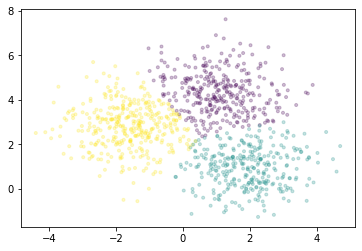

In [36]:
fig, ax = plt.subplots()
ax.scatter(X[::1000, 0], X[::1000, 1], marker='.', c=km.labels_[::1000],
           cmap='viridis', alpha=0.25);